In [1]:
import json
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset

C:\Users\GM\miniconda3\envs\eegmeg\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import json
import numpy as np
from torchvision import models

In [3]:
from os import listdir

In [4]:
num_epochs = 30
batch_size = 32
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
f = open("C:/Users/GM/Desktop/DNA/src/data/strandenergylist.json")
data = json.load(f)
energy = []
strands = []
for pair in data:
    energy.append(pair[1])
    strands.append(pair[0])

In [6]:
intstrands = []
for strand in strands:
    intstrand = []
    for base in strand:
        if base == "A":
            intstrand.append(0)
        if base == "T":
            intstrand.append(1)
        if base == "C":
            intstrand.append(2)
        if base == "G":
            intstrand.append(3)
    intstrands.append(intstrand)

In [7]:
strandstensor = torch.tensor(intstrands)
onehotstrands = F.one_hot(strandstensor, num_classes=4)
onehotstrands = onehotstrands.reshape(1000000,120)
energytensor = torch.tensor(energy)

In [8]:
dataset = TensorDataset(onehotstrands.type(torch.float32), energytensor)
train_set, test_set = torch.utils.data.random_split(dataset, [900000, 100000])
dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
testdataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [9]:
class RegressionLSTM(nn.Module):
    def __init__(self):
        super(RegressionLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size=120, hidden_size=270, num_layers=2, dropout=0.6)
        self.fc1 = nn.Linear(270,1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc1(x)

        return x

In [10]:
lstm = RegressionLSTM()
lstm.to(device)
lstmcriterion = nn.MSELoss()
lstmoptimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [11]:
model_parameters = filter(lambda p: p.requires_grad, lstm.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

1008991


In [12]:
X = onehotstrands.numpy()

In [13]:
y = energytensor.numpy()

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [15]:
RANDOM_SEED = 42

# Split into train,validation and test
X_train, X_val_test, y_train, y_val_test = train_test_split(X,y,test_size=0.2, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val_test,y_val_test,test_size=0.5, random_state=RANDOM_SEED)

In [16]:
X_train.shape, X_val.shape, X_test.shape

((800000, 120), (100000, 120), (100000, 120))

In [17]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [18]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X,y,test_size=0.1, random_state=RANDOM_SEED)

In [19]:
clf_xgb = xgb.XGBRegressor(tree_method='gpu_hist', seed = RANDOM_SEED)
# Fit the model using predictor X and response y.
clf_xgb.fit(X_train, y_train)

# Baseline model
y_pred_train = clf_xgb.predict(X_train)

# RMSE Computation
mse = MSE(y_train, y_pred_train)
rmse = np.sqrt(MSE(y_train, y_pred_train))
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
print("MSE : % f" %(mse))
print("RMSE : % f" %(rmse))
print("MAE : % f" %(mae))
print("R2 : % f" %(r2))

MSE :  0.993166
RMSE :  0.996577
MAE :  0.754646
R2 :  0.398504


In [20]:
y_pred_val = clf_xgb.predict(X_val_test)

mse = MSE(y_val_test, y_pred_val)
rmse = np.sqrt(MSE(y_val_test, y_pred_val))
mae = mean_absolute_error(y_val_test, y_pred_val)
r2 = r2_score(y_val_test, y_pred_val)
print("MSE : % f" %(mse))
print("RMSE : % f" %(rmse))
print("MAE : % f" %(mae))
print("R2 : % f" %(r2))

MSE :  1.016363
RMSE :  1.008148
MAE :  0.762533
R2 :  0.378915


In [26]:
y

-16.34999

In [27]:
column_values = ['Minimum Free Energy']
df = pd.DataFrame(data=y, columns = column_values)

Text(0.5, 1.0, 'MFE of 1M 30-bases DNA sequences')

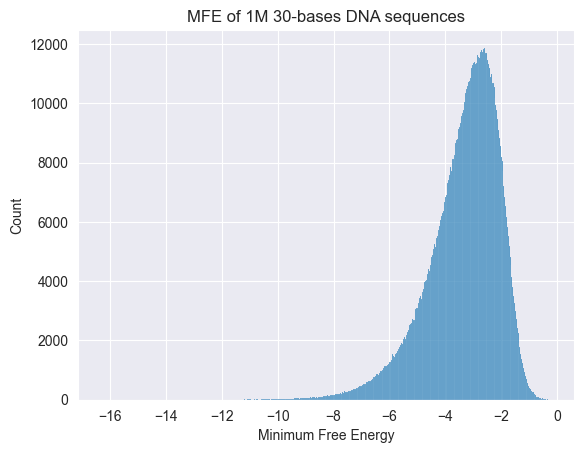

In [30]:
sns.histplot(data=df, x='Minimum Free Energy').set_title('MFE of 1M 30-bases DNA sequences')